# *HL3 bypassed scenario for Man157 Network*

In [1]:
import sys
import os
# Navigate relative to the current working directory
sys.path.append(os.path.abspath('../src'))
import numpy as np
import pandas as pd
from sixdman.core.network import Network
from sixdman.core.band import Band, OpticalParameters
from sixdman.core.planning import PlanningTool
from sixdman.core.visualize import analyse_result
import json
from sixdman.utils.paths import get_project_root

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Use it to get paths
project_root = get_project_root()
results_dir = project_root / "results" / "Man157_75G" / "HL3Bypassed"
results_dir.mkdir(parents=True, exist_ok=True)

## *1. Create Network Instance*

In [3]:
# Initialize network
network = Network(topology_name = 'MAN157')

# Load topology from .mat file
network.load_topology(filepath = '../data/MAN157Nodes.mat', matrixName ='MAN157Nodes')

# Set hierarchical levels
hl_dict = network.define_hierarchy(
    HL1_standalone = [1, 5],
    HL2_standalone = [0, 2, 3, 4],
    HL3_standalone = list(range(6, 39)),
    HL4_standalone = list(range(6, 39)) + list(range(39, 157)), 
    HL4_colocated = [0, 2, 3, 4] + [1, 5]
)

## 2. *Define hierarchy node levels*

In [4]:
HL4_Standalone = hl_dict['HL4']['standalone']
HL4_colocated = hl_dict['HL4']['colocated']

HL3_Standalone = hl_dict['HL3']['standalone']
HL3_colocated = hl_dict['HL3']['colocated']

HL2_Standalone = hl_dict['HL2']['standalone']
HL2_colocated = hl_dict['HL2']['colocated']

HL1_Standalone = hl_dict['HL1']['standalone']

HL123_Standalone = HL1_Standalone + HL2_Standalone + HL3_Standalone
HL12_Standalone = HL1_Standalone + HL2_Standalone


## 3. Define Transmission Bands

In [5]:
# Define C-band parameters
c_band_params = OpticalParameters()

# Create C-band instance
c_band = Band(
    name='C',
    start_freq = 190.65, # THz
    end_freq = 196.675, # THz
    opt_params = c_band_params,
    network_instance = network,
    channel_spacing = 0.075 # THz
    )

# Define L-band parameters
l_band_params = OpticalParameters()

# Create L-band instance
l_band = Band(
    name='L',
    start_freq = 184.525, # THz
    end_freq = 190.565, # THz
    opt_params = l_band_params,
    network_instance = network,
    channel_spacing = 0.075 # THz
)

In [6]:
# define C-band and L-band frequency slots
spectrum_C = c_band.calc_spectrum()
spectrum_L = l_band.calc_spectrum()

# concatenate C-band and KL-band to a sigle frequency spectrum
spectrum = np.concatenate((spectrum_C, spectrum_L))

# define total number of frequency slots
num_fslots = len(spectrum)

f_c_axis = spectrum * 1e12  # Convert to Hz
Pch_dBm = np.arange(-6, -0.9, 0.1)  # Channel power in dBm
num_Ch_mat = np.arange(1, len(spectrum) - 1)  # Channel indices

## 4. Create Planning Tool and Optimize Network

In [7]:
# Initialize planning tool
planner = PlanningTool(
    network_instance = network,
    bands = [c_band, l_band], 
    period_time = 10)

In [8]:
num_level_process = 4
minimum_hierarchy_level = 4
processing_level_list = [4, 2]

In [9]:
for hierarchy_level in processing_level_list:

    print(f"Processing hierarchy level: {hierarchy_level}")

    match hierarchy_level:

        case 2:
            HL_Standalone = HL2_Standalone
            HL_colocated = HL2_colocated
            HL_lower_Standalone = HL4_Standalone
            HL_up_Standalone = HL1_Standalone
            HL_all = np.concatenate((HL2_Standalone, HL2_colocated))
            capacity_updt_index = 1 # if no bypass scenario this variable is 0
            prev_hierarchy_level = 4

        case 4:
            HL_Standalone = HL4_Standalone
            HL_colocated = HL4_colocated
            HL_lower_Standalone = []
            HL_up_Standalone = HL123_Standalone
            HL_all = np.concatenate((HL4_Standalone, HL4_colocated))
            capacity_updt_index = 2
            prev_hierarchy_level = None

    _, subnetMatrix_HL = network.compute_hierarchy_subgraph(hierarchy_level, minimum_hierarchy_level)
    HL_connected_nodes = network.get_neighbor_nodes(HL_Standalone) - set(HL_lower_Standalone)
    
    file_name = results_dir /  f"{network.topology_name}_HL{hierarchy_level}_K_path_attributes.csv"

    if os.path.exists(file_name):

        print(f"Loading K-path attributes of HL{hierarchy_level} ...")

        K_path_attributes_df = pd.read_csv(file_name)
        K_path_attributes_df['links'] = K_path_attributes_df['links'].map(json.loads)
        K_path_attributes_df['nodes'] = K_path_attributes_df['nodes'].map(json.loads)

        # sort dataframes based on num_hops and distance (in order)
        K_path_attributes_df_sorted = K_path_attributes_df.groupby(['src_node'], group_keys = False).apply(lambda x: x.sort_values(['num_hops', 'distance']))

        # Optionally save to CSV (if you want to track progress)
        K_path_attributes_df_sorted.to_csv(f"./../results/Man157_HL3bypassed/{network.topology_name}_HL{hierarchy_level}_K_path_attributes_sorted.csv", index=False)

        # find disjoint pairs for standalone nodes
        pairs_disjoint = network.land_pair_finder(HL_Standalone, K_path_attributes_df_sorted, num_pairs = 1)

    else:

        print(f"Calculating K-path attributes of HL{hierarchy_level} ...")

        k_paths = 100
        source_not_found = HL_Standalone.copy()
        while len(source_not_found) != 0:

            # define a list to store path attributes for this iteration
            K_path_attributes = []

            # iterate through each "source_not_found" node only
            for src in HL_Standalone:
                for dest in HL_connected_nodes:
                    K_path_attributes = network.calculate_paths(subnetMatrix_HL, K_path_attributes, source = src, target = dest, k = k_paths)

            # Convert K_path_attributes list to a temporary DataFrame
            K_path_attributes_df = pd.DataFrame(K_path_attributes)

            # Optionally save to CSV (if you want to track progress)
            K_path_attributes_df.to_csv(file_name, index=False)

            # Sort by num_hops and distance
            K_path_attributes_df_sorted = K_path_attributes_df.groupby(['src_node'], group_keys=False).apply(
                lambda x: x.sort_values(['num_hops', 'distance'])
            )

            # find disjoint pairs from the sorted full dataset
            pairs_disjoint = network.land_pair_finder(HL_Standalone, K_path_attributes_df_sorted, num_pairs=1)

            # Update source_not_found to exclude newly matched source nodes
            source_not_found = np.setdiff1d(HL_Standalone, pairs_disjoint['src_node'].unique())

            print('Remaining src nodes: ', source_not_found)

            k_paths += 20
            print('k_new: ', k_paths)
    
    file_name = results_dir /  f"{network.topology_name}_HL{hierarchy_level}_K_path_attributes_colocated.csv"

    if os.path.exists(file_name):

        print(f"Loading K-path attributes of HL{hierarchy_level} colocated...")

        K_path_attributes_colocated_df = pd.read_csv(file_name)
        K_path_attributes_colocated_df['links'] = K_path_attributes_colocated_df['links'].map(json.loads)
        K_path_attributes_colocated_df['nodes'] = K_path_attributes_colocated_df['nodes'].map(json.loads)

        # sort dataframes based on num_hops and distance (in order)
        K_path_attributes_colocated_df_sorted = K_path_attributes_colocated_df.groupby(['src_node', 'dest_node'], group_keys = False).apply(lambda x: x.sort_values(['num_hops', 'distance']))

    else:

        print(f"Calculating K-path attributes of HL{hierarchy_level} colocated...")
        
        k_paths = 1

        # define a list to store path attributes
        K_path_attributes_colocated = []

        # iterate through each standalone HL4 node
        for src in HL_colocated:
            
            if (hierarchy_level == 3) and (src in HL2_Standalone):
                HL_connected_nodes_col = HL_connected_nodes - set(HL1_Standalone)
            else:
                HL_connected_nodes_col = HL_connected_nodes.copy()

            for dest in HL_connected_nodes:
                if src != dest:
                    K_path_attributes_colocated = network.calculate_paths(subnetMatrix_HL, K_path_attributes_colocated, source = src, target = dest, k = k_paths)

        # Convert K_path_attributes list to dataframe
        K_path_attributes_colocated_df = pd.DataFrame(K_path_attributes_colocated)

        # save dataframe to csv file
        K_path_attributes_colocated_df.to_csv(file_name, index = False)

        # sort dataframes based on num_hops and distance (in order)
        K_path_attributes_colocated_df_sorted = K_path_attributes_colocated_df.groupby(['src_node', 'dest_node'], group_keys = False).apply(lambda x: x.sort_values(['num_hops', 'distance']))

    print(f"process link GSMR of HL{hierarchy_level} ...")

    GSNR_opt_link, _, _, _ = c_band.process_link_gsnr(f_c_axis = f_c_axis, 
                                                  Pch_dBm = Pch_dBm, 
                                                  num_Ch_mat = num_Ch_mat,
                                                  spectrum_C = spectrum_C,
                                                  Nspan_array = np.ones(network.all_links.shape[0], dtype=int),
                                                  hierarchy_level = hierarchy_level, 
                                                  minimum_hierarchy_level = minimum_hierarchy_level, 
                                                  result_directory = results_dir)
    
    planner.initialize_planner(num_fslots = num_fslots, 
                               hierarchy_level = hierarchy_level,
                               minimum_hierarchy_level = minimum_hierarchy_level)
    
    if hierarchy_level == minimum_hierarchy_level:

        # generate port capacity for HL4 nodes uisng Monte Carlo simulation
        planner.generate_initial_traffic_profile(num_nodes = len(HL_all),
                                         monteCarlo_steps = 100,
                                         min_rate = 20, # Gbps
                                         max_rate = 200, # Gbps
                                         seed = 50, 
                                         result_directory = results_dir)

        # Traffic growth simulation over 10 years
        planner.simulate_traffic_annual(lowest_hierarchy_dict = hl_dict[f"HL{hierarchy_level}"], 
                                        CAGR = 0.4,
                                        result_directory = results_dir)
        
    print(f"running planner for HL{hierarchy_level} ...")

    # run the planner for the current hierarchy level    
    planner.run_planner(hierarchy_level = hierarchy_level,
                        prev_hierarchy_level = prev_hierarchy_level, 
                        pairs_disjoint = pairs_disjoint,
                        kpair_standalone = 1,
                        kpair_colocated = 1,
                        candidate_paths_standalone_df = K_path_attributes_df,
                        candidate_paths_colocated_df = K_path_attributes_colocated_df_sorted,
                        GSNR_opt_link = GSNR_opt_link, 
                        minimum_level = minimum_hierarchy_level,
                        node_cap_update_idx = capacity_updt_index, 
                        result_directory = results_dir)


Processing hierarchy level: 4
Loading K-path attributes of HL4 ...
Loading K-path attributes of HL4 colocated...
process link GSMR of HL4 ...
Loading precomputed link GSNR analysis
Loading precomputed HL_capacity_final ...
Loading precomputed Traffic Matrix ...
running planner for HL4 ...
Processing Year:  1
Processing Year:  2
Processing Year:  3
Processing Year:  4
Processing Year:  5
Processing Year:  6
Processing Year:  7
Processing Year:  8
Processing Year:  9
Processing Year:  10
Processing hierarchy level: 2
Loading K-path attributes of HL2 ...
Loading K-path attributes of HL2 colocated...
process link GSMR of HL2 ...
Loading precomputed link GSNR analysis
running planner for HL2 ...
Processing Year:  1
Processing Year:  2
Processing Year:  3
Processing Year:  4
Processing Year:  5
Processing Year:  6
Processing Year:  7
Processing Year:  8
Processing Year:  9
Processing Year:  10


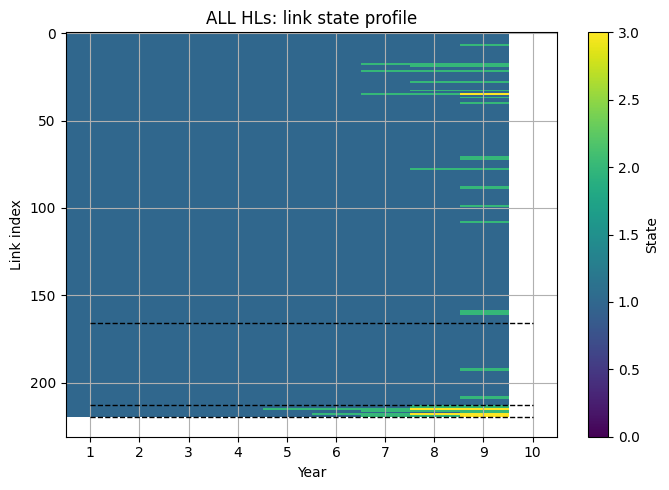

In [10]:
analysing = analyse_result(network, 10, processing_level_list, results_dir)
analysing.plot_link_state(splitter = [166, 47, 7], 
                          flag_plot = 1,
                          save_flag = 0, 
                          save_suffix = "_HL3Bypassed")

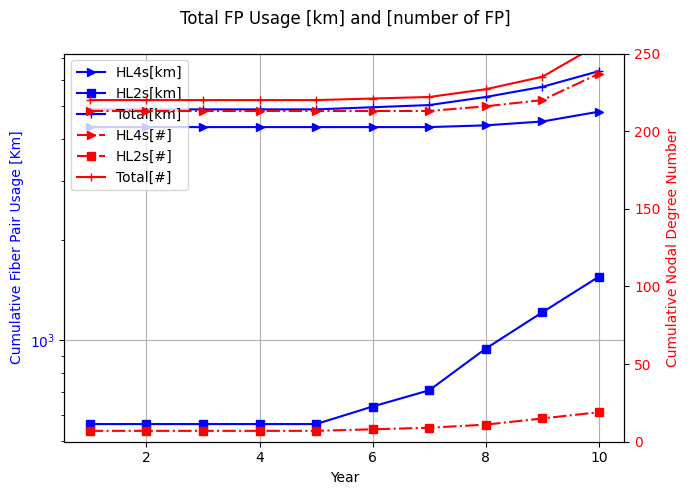

In [11]:
analysing.plot_FP_usage(save_flag = 0, 
                        save_suffix = "_HL3Bypassed")

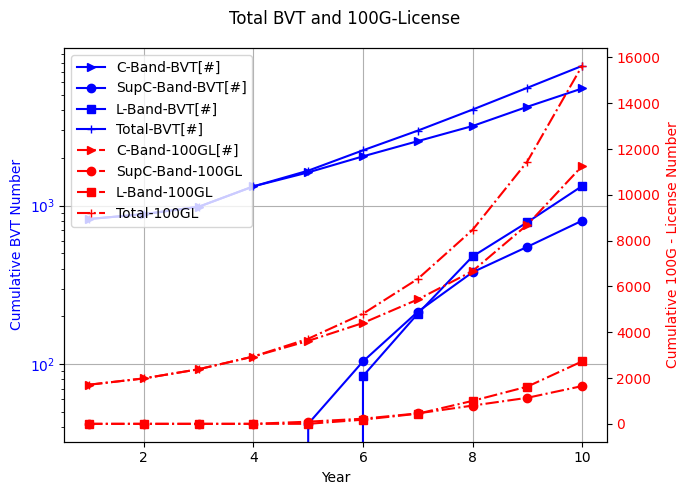

In [12]:
analysing.plot_bvt_license(save_flag = 0, 
                           save_suffix = "_HL3Bypassed")

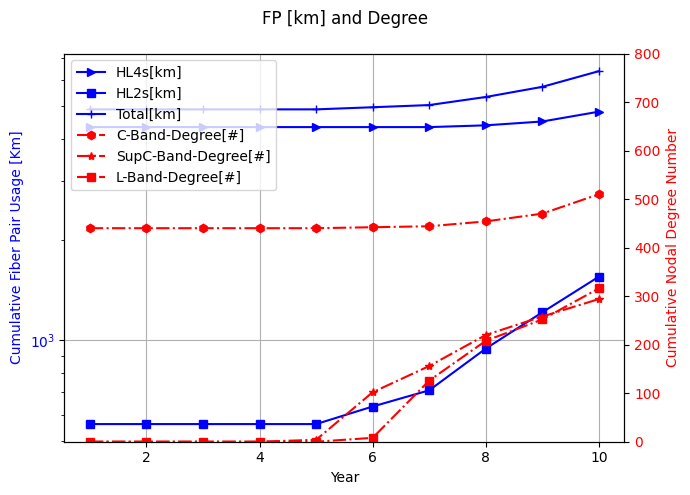

In [13]:
analysing.plot_FP_degree(save_flag = 0, 
                        save_suffix = "_HL3Bypassed")

In [14]:
analysing.calc_cost(save_flag = 0, 
                    save_suffix = "_HL3Bypassed")

,OPEX,Capex_RoB,Capex_MCS,Capex_100GL,CAPEX
0,2450.22,836.000000,36.050000,1708.000000,2580.050000
1,2450.22,0.000000,2.625000,1984.000000,1986.625000
2,2450.22,0.000000,4.375000,2384.000000,2388.375000
3,2450.22,0.000000,14.875000,2940.000000,2954.875000
4,2450.22,0.448772,14.983503,3721.538399,3736.970674
5,2486.36,15.311012,25.559763,4839.082549,4879.953323
6,2523.79,30.154159,33.124133,6392.072498,6455.350790
7,2668.14,37.647840,47.879606,8588.544116,8674.071562
8,2860.98,39.674847,67.132242,11625.878238,11732.685327
9,3187.05,86.864820,93.047178,15879.647893,16059.559891


In [15]:
analysing.calc_latency(primary_paths = planner.primary_path_storage,
                       processing_level_list = processing_level_list, 
                       save_flag = 0)

array([ 905.45,  805.45,  761.85,  876.85, 1020.45,  425.  ,  425.  ,
        736.2 ,  761.2 ,  766.2 ,  811.2 ,  857.9 ,  630.7 ,  440.  ,
        921.2 ,  435.  ,  997.9 ,  431.55,  706.85,  691.55,  740.45,
        531.55,  430.  ,  481.55,  806.85,  415.  , 1195.45,  535.  ,
       1210.45,  450.  ,  480.  ,  490.  ,  530.  ,  811.25,  761.25,
        557.5 ,  711.25,  440.  ,  455.  ,  427.5 ,  422.5 ,  445.  ,
        485.  ,  811.25,  811.25,  481.  ,  478.5 ,  761.25,  475.  ,
        530.  ,  485.  , 1034.35, 1055.45, 1005.45,  955.45,  961.85,
       1055.45,  921.85,  957.85, 1055.45, 1005.45,  899.35,  955.35,
       1006.85,  961.85,  951.85,  916.85,  839.05,  931.85,  507.5 ,
        535.  ,  520.  ,  502.5 ,  525.  ,  565.  ,  555.  ,  565.  ,
        610.  ,  561.  ,  573.5 ,  591.  ,  558.5 ,  675.  ,  665.  ,
        971.85,  921.85,  637.5 ,  745.7 ,  516.55,  685.7 ,  491.55,
        725.7 ,  705.7 ,  680.7 ,  655.7 ,  700.7 ,  735.7 ,  841.2 ,
        876.2 ,  796